# Regression Project Submission

* Students names: Cody Freese/Fennec Nightingale/Thomas Cornett
* Student pace: Part time
* Instructor name: Amber Yandow
* Blog post URL:

## TABLE OF CONTENTS 

*Click to jump to matching Markdown Header.*<br><br>

<font size=3rem>
    
- **[Introduction](#INTRODUCTION)<br>**
- **[OBTAIN](#OBTAIN)**<br>
- **[SCRUB](#SCRUB)**<br>
- **[EXPLORE](#EXPLORE)**<br>
- **[MODEL](#MODEL)**<br>
- **[iNTERPRET](#iNTERPRET)**<br>
- **[Conclusions/Recommendations](#CONCLUSIONS-&-RECOMMENDATIONS)<br>**
</font>
___

# INTRODUCTION

## King County Housing Data
- What factors impact the price of a home?
- What factors impact the price of a home for different income levels?

# OBTAIN

## Import tools

In [294]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import mlxtend
from scipy.stats import zscore
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
pd.options.display.max_rows = 4000
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from statsmodels.stats.outliers_influence import variance_inflation_factor

## King County dataset

In [295]:
# read data
kc_columns = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'condition', 'grade', 'sqft_above', 
              'sqft_basement', 'yr_built']

kc_dtypes = {'id': int, 'date' : str,  'price': float, 'bedrooms' : int, 'bathrooms' : float, 'sqft_living': int, 'sqft_lot': int, 
             'floors': float, 'waterfront': float, 'view' : float, 'condition': float, 'grade': int, 'sqft_above': int, 
             'yr_built': int, 'yr_renovated': float, 'zipcode': float, 'lat': float, 'long': float}

kc_data = pd.read_csv('kc_house_data.csv', dtype = kc_dtypes, parse_dates = ['date'])

kc_data['sqft_basement'] = kc_data['sqft_basement'].replace({'?': 0})
kc_data['sqft_basement'] = kc_data['sqft_basement'].astype(dtype=float, errors='ignore')
kc_data['sqft_total'] = kc_data['sqft_living']*kc_data['sqft_lot']
kc_data['sqft_habitable'] = (kc_data['sqft_above']+1)*(kc_data['sqft_basement']+1)

# SCRUB

### Drop/Outliers

In [296]:
#drop unnessecary columns and fix data
kc_data = kc_data.drop('sqft_living', 1).drop('sqft_lot', 1).drop('id', 1).drop('date', 1).drop('sqft_above',1).drop('sqft_basement',1)

#look for outliers, in bedrooms, we can clearly see a single outlier, for other columns, filtering by z score will be easiest 
kc_data[kc_data['bedrooms'] == 33]
# wouldn't be realistic for a house with 33 bedrooms to only have a sqft_living of 1620 and only 1 3/4 bathrooms so it looks like a typo
# will adjust to 3 
kc_data[kc_data['bedrooms'] == 33] = kc_data[kc_data['bedrooms'] == 33].replace(33,3)

### Waterfront/View/Yr_Renovated NaN

In [297]:
#setting waterfront NaN values equal to the ratio of waterfront/non-waterfront properties, will want to try and narrow by zipcode 
#filling NaN with easily seperatable/changable values helpful 
kc_data['waterfront'] = kc_data['waterfront'].fillna(146/19221)
kc_data['view'] = kc_data['view'].fillna(0)
kc_data['yr_renovated'] = kc_data['yr_renovated'].fillna(0)

### Int to Whole Number Year

In [298]:
#Convert to integer for whole number year
kc_data['yr_renovated'] = kc_data['yr_renovated'].astype('int')

### Categorical Variables

In [299]:
#categorical variables
dumm = pd.get_dummies(kc_data['condition'], prefix='cond', drop_first=True, dtype=int)
kc_data = kc_data.merge(dumm, left_index=True, right_index=True)
dumm = pd.get_dummies(kc_data['view'], prefix='view', drop_first=True, dtype=int)
kc_data = kc_data.merge(dumm, left_index=True, right_index=True)
dumm = pd.get_dummies(kc_data['grade'], prefix='gra', drop_first=True, dtype=int)
kc_data = kc_data.merge(dumm, left_index=True, right_index=True)

### Diversify Variable Ranges

In [300]:
#break up variables into diverse ranges
kc_data = kc_data.rename({'cond_2.0':'con2', 'cond_3.0':'con3','cond_4.0':'con4','cond_5.0':'con5'},axis=1)
kc_data = kc_data.rename({ 'view_1.0': 'view1', 'view_2.0': 'view2', 'view_3.0': 'view3', 'view_4.0':'view4'},axis=1)
kc_data = kc_data.rename({ 'gra_4': 'grd4', 'gra_5':'grd5', 'gra_6':'grd6',
       'gra_7':'grd7', 'gra_8':'grd8', 'gra_9':'grd9', 'gra_10':'grd10', 'gra_11':'grd11', 'gra_12':'grd12', 'gra_13':'grd13'},axis=1)

### Zipcode Sorting

In [301]:
kc_data['zipcode'].sort_values()

8508     98001.0
17199    98001.0
2338     98001.0
8728     98001.0
19729    98001.0
          ...   
10822    98199.0
10897    98199.0
15491    98199.0
10957    98199.0
3110     98199.0
Name: zipcode, Length: 21597, dtype: float64

In [302]:
kc_data['zip1'] = kc_data[(kc_data.zipcode > ) & (kc_data.zipcode<=)]
kc_data['zip2'] = kc_data[(kc_data.zipcode > ) & (kc_data.zipcode<=)]
kc_data['zip3'] = kc_data[(kc_data.zipcode > ) & (kc_data.zipcode<=)]
kc_data['zip4'] = kc_data[(kc_data.zipcode > ) & (kc_data.zipcode<=)]
kc_data['zip5'] = kc_data[(kc_data.zipcode > ) & (kc_data.zipcode<=)]
kc_data['zip6'] = kc_data[(kc_data.zipcode > ) & (kc_data.zipcode<=)]
kc_data['zip7'] = kc_data[(kc_data.zipcode > ) & (kc_data.zipcode<=)]
kc_data['zip8'] = kc_data[(kc_data.zipcode > ) & (kc_data.zipcode<=)]
kc_data['zip9'] = kc_data[(kc_data.zipcode > ) & (kc_data.zipcode<=)]
kc_data['zip10'] = kc_data[(kc_data.zipcode > ) & (kc_data.zipcode<=)]

SyntaxError: invalid syntax (<ipython-input-302-fd359cf6cb67>, line 1)

### Verify Dataframe Info

In [303]:
kc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 35 columns):
price             21597 non-null float64
bedrooms          21597 non-null int32
bathrooms         21597 non-null float64
floors            21597 non-null float64
waterfront        21597 non-null float64
view              21597 non-null float64
condition         21597 non-null float64
grade             21597 non-null int32
yr_built          21597 non-null int32
yr_renovated      21597 non-null int32
zipcode           21597 non-null float64
lat               21597 non-null float64
long              21597 non-null float64
sqft_living15     21597 non-null int64
sqft_lot15        21597 non-null int64
sqft_total        21597 non-null int32
sqft_habitable    21597 non-null float64
con2              21597 non-null int32
con3              21597 non-null int32
con4              21597 non-null int32
con5              21597 non-null int32
view1             21597 non-null int32
view2        

### Recheck for NaN

In [304]:
kc_data.isna().sum()

price             0
bedrooms          0
bathrooms         0
floors            0
waterfront        0
view              0
condition         0
grade             0
yr_built          0
yr_renovated      0
zipcode           0
lat               0
long              0
sqft_living15     0
sqft_lot15        0
sqft_total        0
sqft_habitable    0
con2              0
con3              0
con4              0
con5              0
view1             0
view2             0
view3             0
view4             0
grd4              0
grd5              0
grd6              0
grd7              0
grd8              0
grd9              0
grd10             0
grd11             0
grd12             0
grd13             0
dtype: int64

### For Loop - Value Counts

In [305]:
for col in kc_data.columns:
    try:
        print(col, kc_data[col].value_counts()[:5])
    except:
        print(col, kc_data[col].value_counts())
    print('\n')

price 350000.0     172
450000.0     172
550000.0     159
500000.0     152
425000.0     150
325000.0     148
400000.0     145
375000.0     138
300000.0     133
525000.0     131
250000.0     130
475000.0     120
330000.0     119
650000.0     117
275000.0     113
415000.0     111
315000.0     111
390000.0     110
600000.0     110
440000.0     109
280000.0     109
320000.0     107
435000.0     105
340000.0     103
310000.0     101
335000.0      98
420000.0      97
360000.0      96
260000.0      95
265000.0      94
575000.0      93
625000.0      93
305000.0      92
380000.0      92
430000.0      91
530000.0      91
345000.0      91
270000.0      90
465000.0      89
245000.0      89
700000.0      89
290000.0      88
490000.0      88
370000.0      88
750000.0      87
255000.0      86
410000.0      86
385000.0      86
355000.0      86
230000.0      85
225000.0      83
515000.0      83
485000.0      82
480000.0      81
285000.0      80
235000.0      80
240000.0      79
405000.0      79
365000.0

view 0.0    19485
2.0      957
3.0      508
1.0      330
4.0      317
Name: view, dtype: int64


condition 3.0    14020
4.0     5677
5.0     1701
Name: condition, dtype: int64


grade 7     8974
8     6065
9     2615
6     2038
10    1134
Name: grade, dtype: int64


yr_built 2014    559
2006    453
2005    450
2004    433
2003    420
Name: yr_built, dtype: int64


yr_renovated 0       20853
2014       73
2003       31
2013       31
2007       30
Name: yr_renovated, dtype: int64


zipcode 98103.0    602
98038.0    589
98115.0    583
98052.0    574
98117.0    553
98042.0    547
98034.0    545
98118.0    507
98023.0    499
98006.0    498
98133.0    493
98059.0    468
98058.0    455
98155.0    446
98074.0    441
98033.0    432
98027.0    412
98125.0    409
98056.0    406
98053.0    403
98001.0    361
98075.0    359
98126.0    354
98092.0    351
98144.0    343
98106.0    335
98116.0    330
98029.0    321
98004.0    317
98199.0    317
98065.0    308
98122.0    290
98146.0    288
98008.0    2

### Drop Condition Has No Values Present

In [306]:
kc_data = kc_data.drop('con3', axis=1).drop('grd13', axis=1)

## Summary

In [307]:
kc_data.describe().round(3)

,price,bedrooms,bathrooms,floors,waterfront,view,condition,grade,yr_built,yr_renovated,...,view4,grd4,grd5,grd6,grd7,grd8,grd9,grd10,grd11,grd12
count,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,...,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000
mean,540296.574,3.372,2.116,1.494,0.008,0.233,3.410,7.658,1971.000,68.758,...,0.015,0.001,0.011,0.094,0.416,0.281,0.121,0.053,0.018,0.004
std,367368.140,0.904,0.769,0.540,0.082,0.765,0.651,1.173,29.375,364.037,...,0.120,0.035,0.105,0.292,0.493,0.449,0.326,0.223,0.135,0.064
min,78000.000,1.000,0.500,1.000,0.000,0.000,1.000,3.000,1900.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,322000.000,3.000,1.750,1.000,0.000,0.000,3.000,7.000,1951.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,450000.000,3.000,2.250,1.500,0.000,0.000,3.000,7.000,1975.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,645000.000,4.000,2.500,2.000,0.000,0.000,4.000,8.000,1997.000,0.000,...,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000
max,7700000.000,11.000,8.000,3.500,1.000,4.000,5.000,13.000,2015.000,2015.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


# EXPLORE

## Histogram

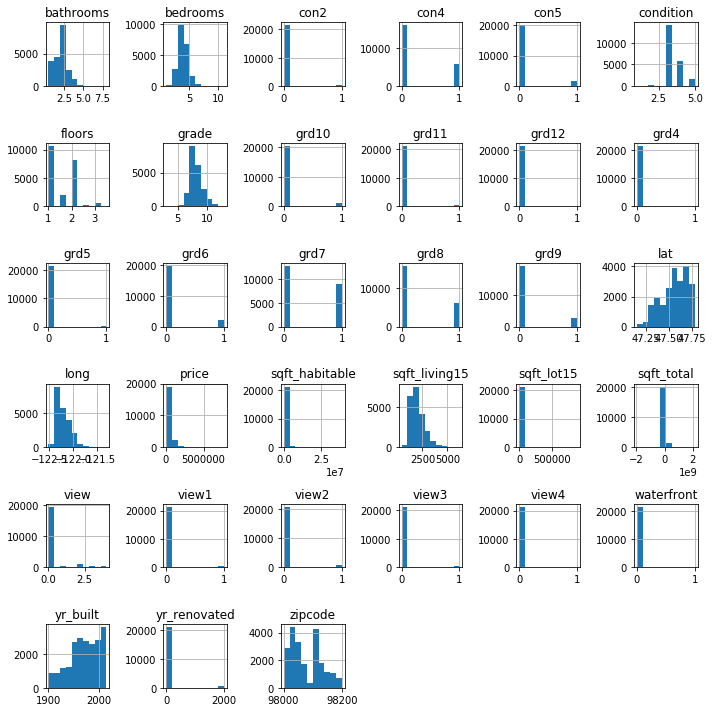

In [308]:
kc_data.hist(figsize=(10,10))
plt.tight_layout()

## Scatter Matrix

C:\Users\c_fre\anaconda3\envs\learn-env\lib\site-packages\pandas\plotting\_matplotlib\misc.py:49: RuntimeWarning: overflow encountered in long_scalars
  rdelta_ext = (rmax_ - rmin_) * range_padding / 2.0


<class 'numpy.ndarray'>


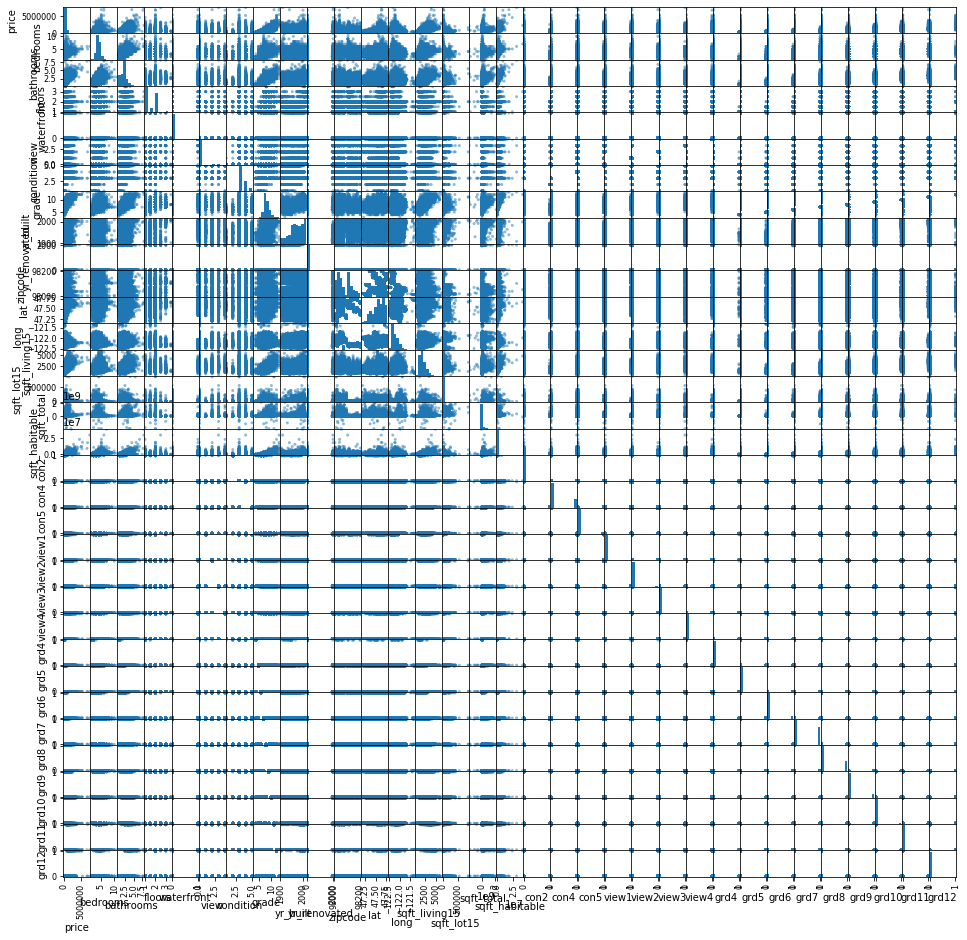

In [309]:
fig = pd.plotting.scatter_matrix(kc_data,figsize=(16,16));
print(type(fig))

## Heatmap

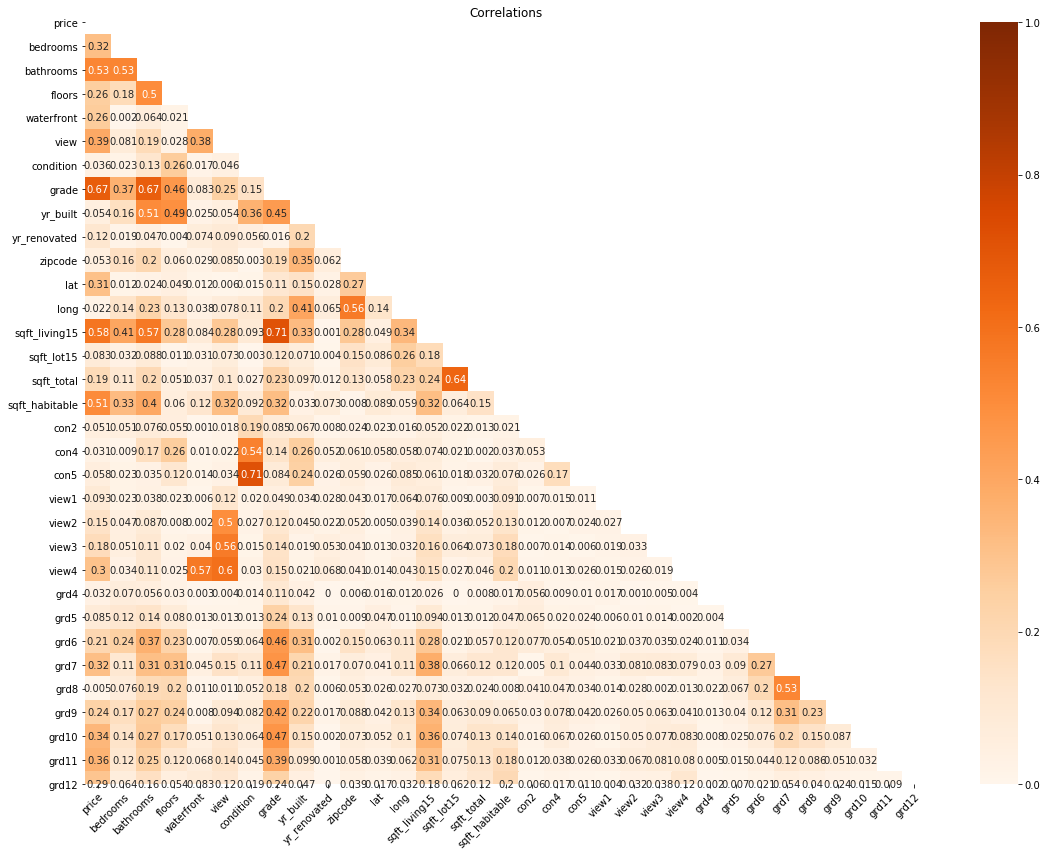

In [310]:
fig, ax = plt.subplots(figsize=(16,12))
corr = kc_data.corr().abs().round(3)
mask = np.triu(np.ones_like(corr, dtype=np.bool))
sns.heatmap(corr, annot=True, mask=mask, cmap='Oranges', ax=ax)
plt.setp(ax.get_xticklabels(), 
         rotation=45, 
         ha="right",
         rotation_mode="anchor")
ax.set_title('Correlations')
fig.tight_layout()

# MODEL

## Initial Model on Price

In [311]:
# Initial Model - Price's Not Separated into Ranges
outcome = 'price'
x_cols = ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'yr_built', 'yr_renovated', 'zipcode', 'lat',
       'long', 'sqft_total', 'sqft_habitable',
       'con2', 'con4', 'con5', 'view1', 'view2', 'view3', 'view4', 'grd4',
       'grd5', 'grd6', 'grd7', 'grd8', 'grd9', 'grd10', 'grd11', 'grd12']

In [312]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=kc_data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     2023.
Date:                Mon, 14 Dec 2020   Prob (F-statistic):               0.00
Time:                        09:10:54   Log-Likelihood:            -2.9377e+05
No. Observations:               21597   AIC:                         5.876e+05
Df Residuals:                   21569   BIC:                         5.878e+05
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       3.017e+07   2.77e+06     10.884      0.000    2.47e+07    3.56e+07
bedrooms        6641.2895   1809.278      3.671      0.000    3094.971    1.02e+04
bathrooms       7.269e+04   3009.868     24.151      0.000    6.68e+04    7.86e+04
floors          4.929e+04   3291.983     14.972      0.000    4.28e+04    5.57e+04
waterfront      5.618e+05   1.98e+04     28.303      0.000    5.23e+05    6.01e+05
view            5.407e+04   2215.353     24.408      0.000    4.97e+04    5.84e+04
yr_built       -2401.9123     71.217    -33.727      0.000   -2541.502   -2262.323
yr_renovated      32.3107      3.882      8.322      0.000      24.701      39.921
zipcode         -635.0498     32.113    -19.775      0.000    -697.994    -572.105
lat             5.985e+05   1.04e+04     57.495      0.000    5.78e+05    6.19e+05
long           -8.812e+04   1.23e+04     -7.152      0.000   -1.12e+05    -6.4e+04
sqft_total      2.751e-05   1.31e-05      2.092      0.036    1.74e-06    5.33e-05
sqft_habitable     0.0571      0.002     35.005      0.000       0.054       0.060
con2           -1.222e+04   1.53e+04     -0.800      0.424   -4.21e+04    1.77e+04
con4            2.924e+04   3386.859      8.635      0.000    2.26e+04    3.59e+04
con5            6.369e+04   5395.944     11.803      0.000    5.31e+04    7.43e+04
view1           7.443e+04   1.07e+04      6.955      0.000    5.35e+04    9.54e+04
view2          -3.177e+04   6782.040     -4.685      0.000   -4.51e+04   -1.85e+04
view3          -3.067e+04   8105.674     -3.784      0.000   -4.66e+04   -1.48e+04
view4            3.38e+04   7524.473      4.492      0.000    1.91e+04    4.86e+04
grd4           -2.372e+06   6.59e+04    -35.974      0.000    -2.5e+06   -2.24e+06
grd5           -2.371e+06   5.55e+04    -42.724      0.000   -2.48e+06   -2.26e+06
grd6           -2.322e+06   5.42e+04    -42.870      0.000   -2.43e+06   -2.22e+06
grd7           -2.258e+06   5.38e+04    -41.939      0.000   -2.36e+06   -2.15e+06
grd8            -2.16e+06   5.37e+04    -40.230      0.000   -2.27e+06   -2.05e+06
grd9           -1.971e+06   5.37e+04    -36.714      0.000   -2.08e+06   -1.87e+06
grd10          -1.752e+06   5.37e+04    -32.617      0.000   -1.86e+06   -1.65e+06
grd11          -1.446e+06   5.41e+04    -26.742      0.000   -1.55e+06   -1.34e+06
grd12          -9.609e+05   5.67e+04    -16.941      0.000   -1.07e+06    -8.5e+05
==============================================================================
Omnibus:                    13502.023   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           694896.509
Skew:                           2.340   Prob(JB):                         0.00
Kurtosis:                      30.392   Cond. No.                     1.05e+16
================================

## Regression Results

In [313]:
model.params.sort_values()

grd4             -2.371916e+06
grd5             -2.370804e+06
grd6             -2.321864e+06
grd7             -2.257956e+06
grd8             -2.160166e+06
grd9             -1.970724e+06
grd10            -1.751779e+06
grd11            -1.446165e+06
grd12            -9.608800e+05
long             -8.811793e+04
view2            -3.177219e+04
view3            -3.067267e+04
con2             -1.221597e+04
yr_built         -2.401912e+03
zipcode          -6.350498e+02
sqft_total        2.750954e-05
sqft_habitable    5.709188e-02
yr_renovated      3.231072e+01
bedrooms          6.641289e+03
con4              2.924453e+04
view4             3.380150e+04
floors            4.928663e+04
view              5.407131e+04
con5              6.369062e+04
bathrooms         7.269071e+04
view1             7.442768e+04
waterfront        5.617862e+05
lat               5.985185e+05
Intercept         3.016853e+07
dtype: float64

LOW


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.977
Model:                            OLS   Adj. R-squared (uncentered):              0.977
Method:                 Least Squares   F-statistic:                          1.290e+04
Date:                Mon, 14 Dec 2020   Prob (F-statistic):                        0.00
Time:                        09:10:54   Log-Likelihood:                         -54455.
No. Observations:                4561   AIC:                                  1.089e+05
Df Residuals:                    4546   BIC:                                  1.090e+05
Df Model:                          15                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
bedrooms        2729.6298    828.956      3.293      0.001    1104.474    4354.786
bathrooms       2.229e+04   1339.933     16.636      0.000    1.97e+04    2.49e+04
floors          8880.2329   1679.977      5.286      0.000    5586.662    1.22e+04
waterfront      1.009e+05   2.63e+04      3.837      0.000    4.94e+04    1.52e+05
zipcode          -36.1396      6.491     -5.568      0.000     -48.865     -23.414
lat             1.134e+05   5319.035     21.319      0.000    1.03e+05    1.24e+05
long             1.35e+04   4535.989      2.976      0.003    4605.061    2.24e+04
sqft_total         0.0001      2e-05      5.346      0.000    6.76e-05       0.000
sqft_habitable     0.0115      0.002      6.085      0.000       0.008       0.015
con4            7995.1006   1263.870      6.326      0.000    5517.302    1.05e+04
con5            1.417e+04   2272.698      6.235      0.000    9715.562    1.86e+04
view1           3.317e+04   1.03e+04      3.208      0.001    1.29e+04    5.35e+04
grd4           -6.085e+04   8250.524     -7.375      0.000    -7.7e+04   -4.47e+04
grd5           -4.096e+04   2965.700    -13.811      0.000   -4.68e+04   -3.51e+04
grd6           -1.619e+04   1463.792    -11.062      0.000   -1.91e+04   -1.33e+04
==============================================================================
Omnibus:                      244.200   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              287.168
Skew:                          -0.575   Prob(JB):                     4.39e-63
Kurtosis:                       3.434   Cond. No.                     1.51e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.51e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

MID


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.962
Model:                            OLS   Adj. R-squared (uncentered):              0.962
Method:                 Least Squares   F-statistic:                          2.218e+04
Date:                Mon, 14 Dec 2020   Prob (F-statistic):                        0.00
Time:                        09:10:54   Log-Likelihood:                     -1.8233e+05
No. Observations:               14093   AIC:                                  3.647e+05
Df Residuals:                   14077   BIC:                                  3.648e+05
Df Model:                          16                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
bathrooms       4.453e+04   1778.651     25.036      0.000     4.1e+04     4.8e+04
waterfront      8.245e+04   1.83e+04      4.506      0.000    4.66e+04    1.18e+05
view            2.248e+04   1480.489     15.187      0.000    1.96e+04    2.54e+04
yr_built       -1609.8439     41.644    -38.657      0.000   -1691.472   -1528.215
zipcode          -44.1154     10.504     -4.200      0.000     -64.705     -23.525
lat             3.633e+05   7069.581     51.385      0.000    3.49e+05    3.77e+05
long            7.783e+04   7848.930      9.915      0.000    6.24e+04    9.32e+04
sqft_habitable     0.0087      0.001      6.389      0.000       0.006       0.011
con4            1.256e+04   2120.849      5.922      0.000    8402.765    1.67e+04
con5            3.154e+04   3473.271      9.081      0.000    2.47e+04    3.83e+04
view1           3.679e+04   7307.448      5.034      0.000    2.25e+04    5.11e+04
grd7            6.005e+04   3749.345     16.016      0.000    5.27e+04    6.74e+04
grd8            1.416e+05   4151.330     34.105      0.000    1.33e+05     1.5e+05
grd9            2.463e+05   4828.781     50.996      0.000    2.37e+05    2.56e+05
grd10           3.147e+05   6772.669     46.469      0.000    3.01e+05    3.28e+05
grd11           3.338e+05    2.2e+04     15.204      0.000    2.91e+05    3.77e+05
==============================================================================
Omnibus:                      369.930   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              399.138
Skew:                           0.411   Prob(JB):                     2.13e-87
Kurtosis:                       3.066   Cond. No.                     2.09e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.09e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

HIGH


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.925
Model:                            OLS   Adj. R-squared (uncentered):              0.924
Method:                 Least Squares   F-statistic:                              1997.
Date:                Mon, 14 Dec 2020   Prob (F-statistic):                        0.00
Time:                        09:10:54   Log-Likelihood:                         -41869.
No. Observations:                2943   AIC:                                  8.377e+04
Df Residuals:                    2925   BIC:                                  8.388e+04
Df Model:                          18                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
bathrooms       1.345e+05    1.1e+04     12.223      0.000    1.13e+05    1.56e+05
waterfront      7.929e+05   3.64e+04     21.763      0.000    7.21e+05    8.64e+05
yr_built       -1658.6813    298.585     -5.555      0.000   -2244.140   -1073.223
yr_renovated      32.2092     13.627      2.364      0.018       5.490      58.928
zipcode        -1944.9679    107.433    -18.104      0.000   -2155.620   -1734.316
lat             8.088e+05   1.04e+05      7.755      0.000    6.04e+05    1.01e+06
long           -1.293e+06   7.72e+04    -16.750      0.000   -1.44e+06   -1.14e+06
sqft_habitable     0.0509      0.004     13.420      0.000       0.043       0.058
con4            6.893e+04   1.82e+04      3.788      0.000    3.33e+04    1.05e+05
con5            7.069e+04    2.5e+04      2.825      0.005    2.16e+04     1.2e+05
view1           7.051e+04   3.47e+04      2.034      0.042    2549.005    1.38e+05
grd4            7.171e-09   4.11e-10     17.429      0.000    6.36e-09    7.98e-09
grd6           -2.028e+06   1.55e+05    -13.044      0.000   -2.33e+06   -1.72e+06
grd7            -2.12e+06   1.12e+05    -18.978      0.000   -2.34e+06    -1.9e+06
grd8            -2.06e+06   1.08e+05    -19.083      0.000   -2.27e+06   -1.85e+06
grd9           -1.917e+06   1.07e+05    -17.964      0.000   -2.13e+06   -1.71e+06
grd10          -1.715e+06   1.06e+05    -16.117      0.000   -1.92e+06   -1.51e+06
grd11          -1.498e+06   1.07e+05    -14.066      0.000   -1.71e+06   -1.29e+06
grd12          -1.049e+06   1.11e+05     -9.487      0.000   -1.27e+06   -8.32e+05
==============================================================================
Omnibus:                     1099.814   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9465.762
Skew:                           1.531   Prob(JB):                         0.00
Kurtosis:                      11.235   Cond. No.                     2.67e+23
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.65e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

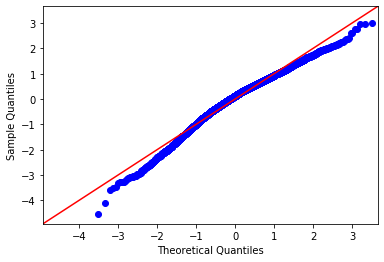

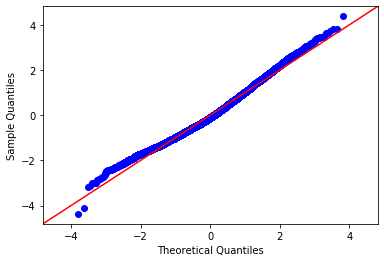

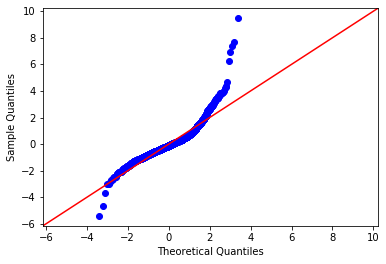

In [314]:
# Adding in varaible income levels, each income has varaibles with cooresponding p values <0.05

lowtier = kc_data[kc_data.price <=300000]
midtier = kc_data[(kc_data.price > 300001) & (kc_data.price<=800000) ]
hightier = kc_data[kc_data.price >800000]

lowincome = ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'zipcode', 'lat',
       'long', 'sqft_total', 'sqft_habitable', 'con4', 'con5', 'view1', 'grd4',
       'grd5', 'grd6']

mediumincome = ['bathrooms', 'waterfront', 'view', 'yr_built',
                  'zipcode', 'lat','long', 'sqft_habitable',
                   'con4', 'con5', 'view1','grd7', 'grd8', 'grd9', 
                  'grd10', 'grd11']
highincome = [ 'bathrooms', 'waterfront','yr_built', 
                   'yr_renovated', 'zipcode', 'lat','long', 'sqft_habitable',
                   'con4', 'con5', 'view1', 'grd4', 'grd6',
                   'grd7', 'grd8', 'grd9', 'grd10', 'grd11', 'grd12']

def make_ols(df, x_columns, drops=None, target='price', add_constant=False):
    if drops:
        drops.append(target)
        X = df.drop(columns=drops)
    else:
        X = df[x_columns]
    if add_constant:
        X = sm.add_constant(X)
    y = df[target]
    ols = sm.OLS(y, X)
    res = ols.fit()
    display(res.summary())
    fig = sm.graphics.qqplot(res.resid, dist=stats.norm, line='45', fit=True)
    return res
price_tiers = [
    ('low', lowtier, lowincome), 
    ('mid', midtier, mediumincome), 
    ('high', hightier, highincome)
]
for name, tier, income in price_tiers:
    print(name.upper())
    make_ols(tier, income)

## Refinement

In [315]:
# Attempt to find a more normalized price range
kc_columns = ['price']

In [316]:
for col in kc_columns:
    col_zscore = str(col + '_zscore')
    kc_data[col_zscore] = (kc_data[col] - kc_data[col].mean())/kc_data[col].std()
    kc_data = kc_data.loc[kc_data[col_zscore] < 2.25]
    kc_data = kc_data.loc[kc_data[col_zscore] > (-2.25)]
    kc_data = kc_data.drop(col_zscore, axis = 1)

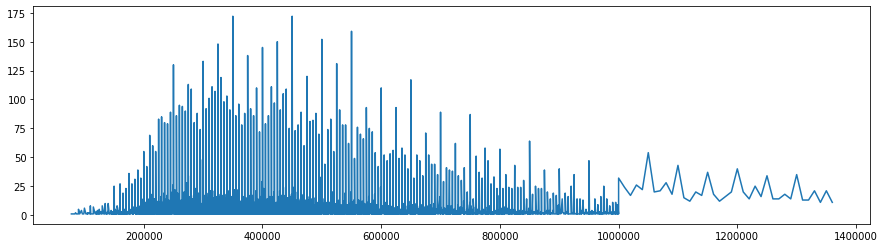

In [317]:
plt.figure(figsize=(15,4))
plt.plot(kc_data['price'].value_counts().sort_index())

In [318]:
# Income Percentiles

for i in range(1,100):
    q = i / 100
    print('{} percentile: {}'.format(q, kc_data['price'].quantile(q=q)))

0.01 percentile: 153000.0
0.02 percentile: 175000.0
0.03 percentile: 190000.0
0.04 percentile: 200000.0
0.05 percentile: 210000.0
0.06 percentile: 218000.0
0.07 percentile: 225000.0
0.08 percentile: 230000.0
0.09 percentile: 239000.0
0.1 percentile: 245000.0
0.11 percentile: 250000.0
0.12 percentile: 254000.0
0.13 percentile: 259900.0
0.14 percentile: 265000.0
0.15 percentile: 269950.0
0.16 percentile: 275000.0
0.17 percentile: 279000.0
0.18 percentile: 284000.0
0.19 percentile: 289056.0
0.2 percentile: 294370.0
0.21 percentile: 299900.0
0.22 percentile: 302949.60000000003
0.23 percentile: 308950.0
0.24 percentile: 313500.0
0.25 percentile: 319000.0
0.26 percentile: 324000.0
0.27 percentile: 326617.36000000034
0.28 percentile: 330000.0
0.29 percentile: 335000.0
0.3 percentile: 340000.0
0.31 percentile: 345000.0
0.32 percentile: 350000.0
0.33 percentile: 355000.0
0.34 percentile: 359950.0
0.35 percentile: 365000.0
0.36 percentile: 370000.0
0.37 percentile: 375000.0
0.38 percentile: 3800

## Refined Model

LOW


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.977
Model:                            OLS   Adj. R-squared (uncentered):              0.977
Method:                 Least Squares   F-statistic:                          1.290e+04
Date:                Mon, 14 Dec 2020   Prob (F-statistic):                        0.00
Time:                        09:10:55   Log-Likelihood:                         -54455.
No. Observations:                4561   AIC:                                  1.089e+05
Df Residuals:                    4546   BIC:                                  1.090e+05
Df Model:                          15                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
bedrooms        2729.6298    828.956      3.293      0.001    1104.474    4354.786
bathrooms       2.229e+04   1339.933     16.636      0.000    1.97e+04    2.49e+04
floors          8880.2329   1679.977      5.286      0.000    5586.662    1.22e+04
waterfront      1.009e+05   2.63e+04      3.837      0.000    4.94e+04    1.52e+05
zipcode          -36.1396      6.491     -5.568      0.000     -48.865     -23.414
lat             1.134e+05   5319.035     21.319      0.000    1.03e+05    1.24e+05
long             1.35e+04   4535.989      2.976      0.003    4605.061    2.24e+04
sqft_total         0.0001      2e-05      5.346      0.000    6.76e-05       0.000
sqft_habitable     0.0115      0.002      6.085      0.000       0.008       0.015
con4            7995.1006   1263.870      6.326      0.000    5517.302    1.05e+04
con5            1.417e+04   2272.698      6.235      0.000    9715.562    1.86e+04
view1           3.317e+04   1.03e+04      3.208      0.001    1.29e+04    5.35e+04
grd4           -6.085e+04   8250.524     -7.375      0.000    -7.7e+04   -4.47e+04
grd5           -4.096e+04   2965.700    -13.811      0.000   -4.68e+04   -3.51e+04
grd6           -1.619e+04   1463.792    -11.062      0.000   -1.91e+04   -1.33e+04
==============================================================================
Omnibus:                      244.200   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              287.168
Skew:                          -0.575   Prob(JB):                     4.39e-63
Kurtosis:                       3.434   Cond. No.                     1.51e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.51e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

MID


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.962
Model:                            OLS   Adj. R-squared (uncentered):              0.962
Method:                 Least Squares   F-statistic:                          2.218e+04
Date:                Mon, 14 Dec 2020   Prob (F-statistic):                        0.00
Time:                        09:10:55   Log-Likelihood:                     -1.8233e+05
No. Observations:               14093   AIC:                                  3.647e+05
Df Residuals:                   14077   BIC:                                  3.648e+05
Df Model:                          16                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
bathrooms       4.453e+04   1778.651     25.036      0.000     4.1e+04     4.8e+04
waterfront      8.245e+04   1.83e+04      4.506      0.000    4.66e+04    1.18e+05
view            2.248e+04   1480.489     15.187      0.000    1.96e+04    2.54e+04
yr_built       -1609.8439     41.644    -38.657      0.000   -1691.472   -1528.215
zipcode          -44.1154     10.504     -4.200      0.000     -64.705     -23.525
lat             3.633e+05   7069.581     51.385      0.000    3.49e+05    3.77e+05
long            7.783e+04   7848.930      9.915      0.000    6.24e+04    9.32e+04
sqft_habitable     0.0087      0.001      6.389      0.000       0.006       0.011
con4            1.256e+04   2120.849      5.922      0.000    8402.765    1.67e+04
con5            3.154e+04   3473.271      9.081      0.000    2.47e+04    3.83e+04
view1           3.679e+04   7307.448      5.034      0.000    2.25e+04    5.11e+04
grd7            6.005e+04   3749.345     16.016      0.000    5.27e+04    6.74e+04
grd8            1.416e+05   4151.330     34.105      0.000    1.33e+05     1.5e+05
grd9            2.463e+05   4828.781     50.996      0.000    2.37e+05    2.56e+05
grd10           3.147e+05   6772.669     46.469      0.000    3.01e+05    3.28e+05
grd11           3.338e+05    2.2e+04     15.204      0.000    2.91e+05    3.77e+05
==============================================================================
Omnibus:                      369.930   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              399.138
Skew:                           0.411   Prob(JB):                     2.13e-87
Kurtosis:                       3.066   Cond. No.                     2.09e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.09e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

HIGH


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.979
Model:                            OLS   Adj. R-squared (uncentered):              0.979
Method:                 Least Squares   F-statistic:                          2.074e+04
Date:                Mon, 14 Dec 2020   Prob (F-statistic):                        0.00
Time:                        09:10:55   Log-Likelihood:                         -30059.
No. Observations:                2259   AIC:                                  6.013e+04
Df Residuals:                    2254   BIC:                                  6.016e+04
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
bathrooms       4.762e+04   4728.382     10.070      0.000    3.83e+04    5.69e+04
waterfront      1.167e+05   2.56e+04      4.564      0.000    6.66e+04    1.67e+05
zipcode         -324.0607     39.998     -8.102      0.000    -402.497    -245.624
long           -2.669e+05   3.21e+04     -8.324      0.000    -3.3e+05   -2.04e+05
sqft_habitable     0.0131      0.002      5.633      0.000       0.009       0.018
==============================================================================
Omnibus:                      176.861   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              211.925
Skew:                           0.735   Prob(JB):                     9.57e-47
Kurtosis:                       2.704   Cond. No.                     1.86e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.86e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

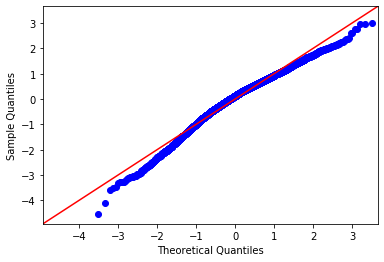

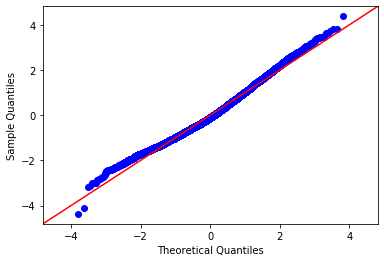

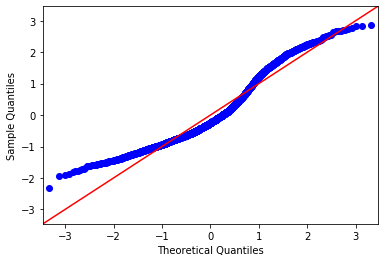

In [319]:
#Removed P values >= 0.05 relative to income tier

lowtier = kc_data[kc_data.price <=300000]
midtier = kc_data[(kc_data.price > 300001) & (kc_data.price<=800000) ]
hightier = kc_data[kc_data.price >800000]

lowincome = ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'zipcode', 'lat',
       'long', 'sqft_total', 'sqft_habitable', 'con4', 'con5', 'view1', 'grd4',
       'grd5', 'grd6']

mediumincome = ['bathrooms', 'waterfront', 'view', 'yr_built',
                  'zipcode', 'lat','long', 'sqft_habitable',
                   'con4', 'con5', 'view1','grd7', 'grd8', 'grd9', 
                  'grd10', 'grd11']
highincome = [ 'bathrooms', 'waterfront', 'zipcode','long', 'sqft_habitable']

def make_ols(df, x_columns, drops=None, target='price', add_constant=False):
    if drops:
        drops.append(target)
        X = df.drop(columns=drops)
    else:
        X = df[x_columns]
    if add_constant:
        X = sm.add_constant(X)
    y = df[target]
    ols = sm.OLS(y, X)
    res = ols.fit()
    display(res.summary())
    fig = sm.graphics.qqplot(res.resid, dist=stats.norm, line='45', fit=True)
    return res
price_tiers = [
    ('low', lowtier, lowincome), 
    ('mid', midtier, mediumincome), 
    ('high', hightier, highincome)
]
for name, tier, income in price_tiers:
    print(name.upper())
    make_ols(tier, income)

In [320]:
kc_data.describe()

,price,bedrooms,bathrooms,floors,waterfront,view,condition,grade,yr_built,yr_renovated,...,view4,grd4,grd5,grd6,grd7,grd8,grd9,grd10,grd11,grd12
count,2.091300e+04,20913.000000,20913.000000,20913.000000,20913.000000,20913.000000,20913.000000,20913.000000,20913.000000,20913.000000,...,20913.000000,20913.000000,20913.000000,20913.000000,20913.000000,20913.000000,20913.000000,20913.000000,20913.000000,20913.000000
mean,4.939519e+05,3.345622,2.072670,1.482260,0.004091,0.191508,3.407498,7.575001,1970.865299,63.550854,...,0.009085,0.001291,0.011572,0.097451,0.428872,0.288050,0.118204,0.043370,0.010615,0.000526
std,2.347989e+05,0.891220,0.724039,0.537136,0.056933,0.680362,0.648084,1.076915,29.254543,350.420525,...,0.094885,0.035909,0.106950,0.296578,0.494927,0.452866,0.322857,0.203694,0.102485,0.022929
min,7.800000e+04,1.000000,0.500000,1.000000,0.000000,0.000000,1.000000,3.000000,1900.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.190000e+05,3.000000,1.500000,1.000000,0.000000,0.000000,3.000000,7.000000,1951.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.425000e+05,3.000000,2.250000,1.000000,0.000000,0.000000,3.000000,7.000000,1975.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.200000e+05,4.000000,2.500000,2.000000,0.000000,0.000000,4.000000,8.000000,1996.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.360000e+06,11.000000,7.500000,3.500000,1.000000,4.000000,5.000000,12.000000,2015.000000,2015.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


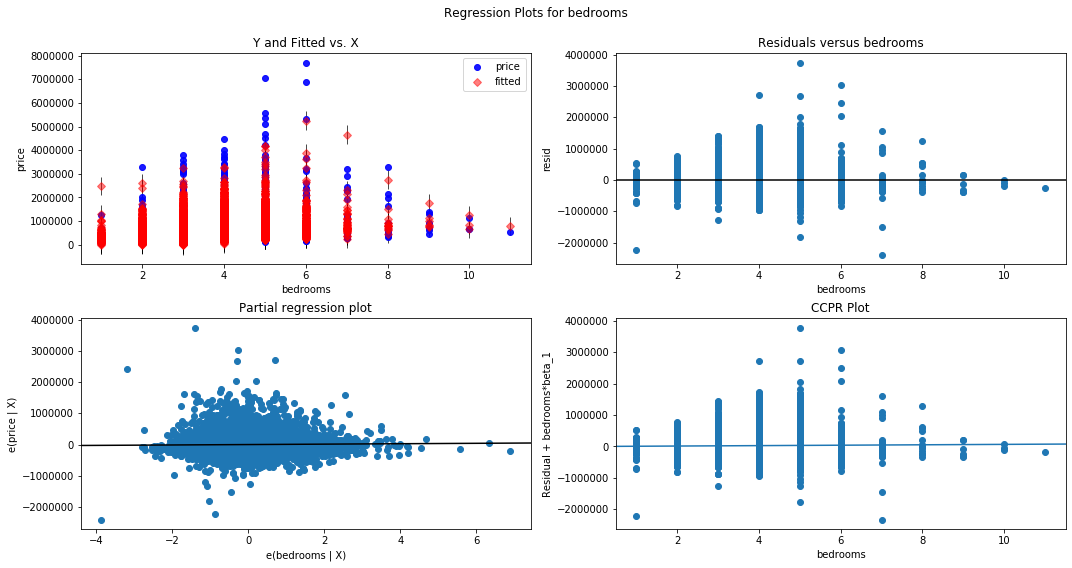

In [321]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "bedrooms", fig=fig)
plt.show()

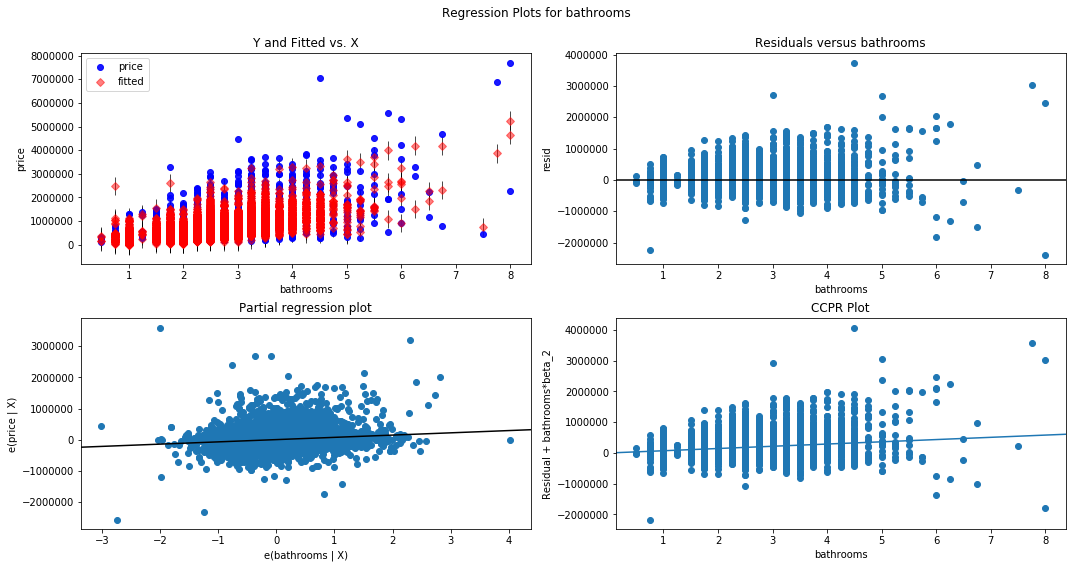

In [322]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "bathrooms", fig=fig)
plt.show()

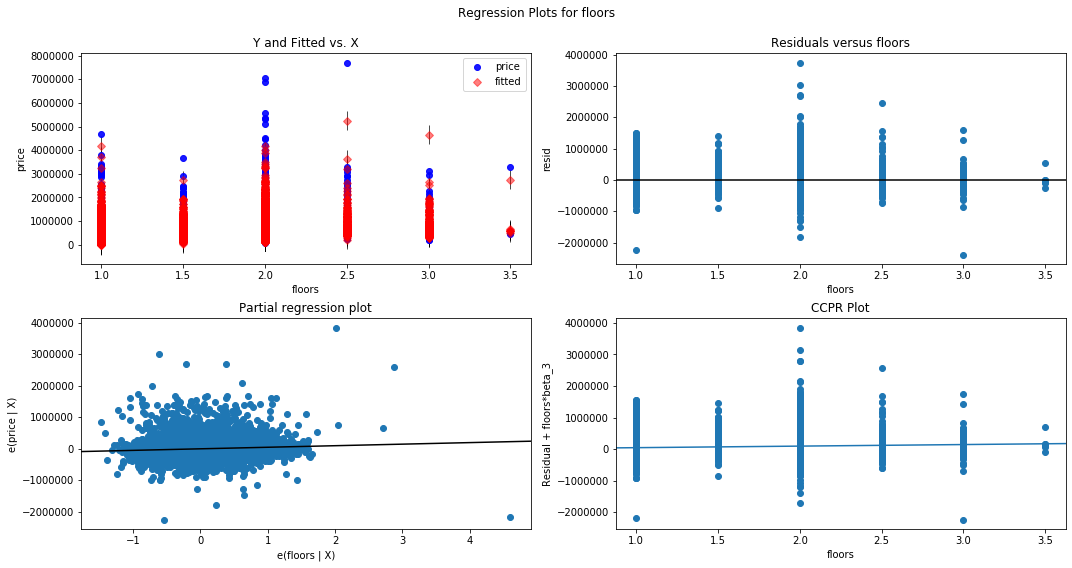

In [323]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "floors", fig=fig)
plt.show()

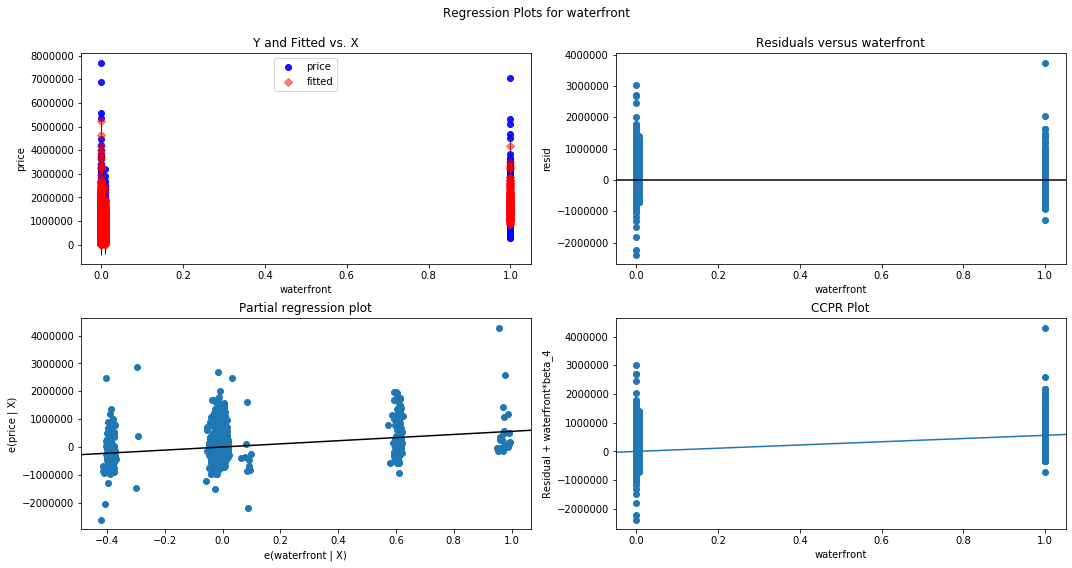

In [324]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "waterfront", fig=fig)
plt.show()

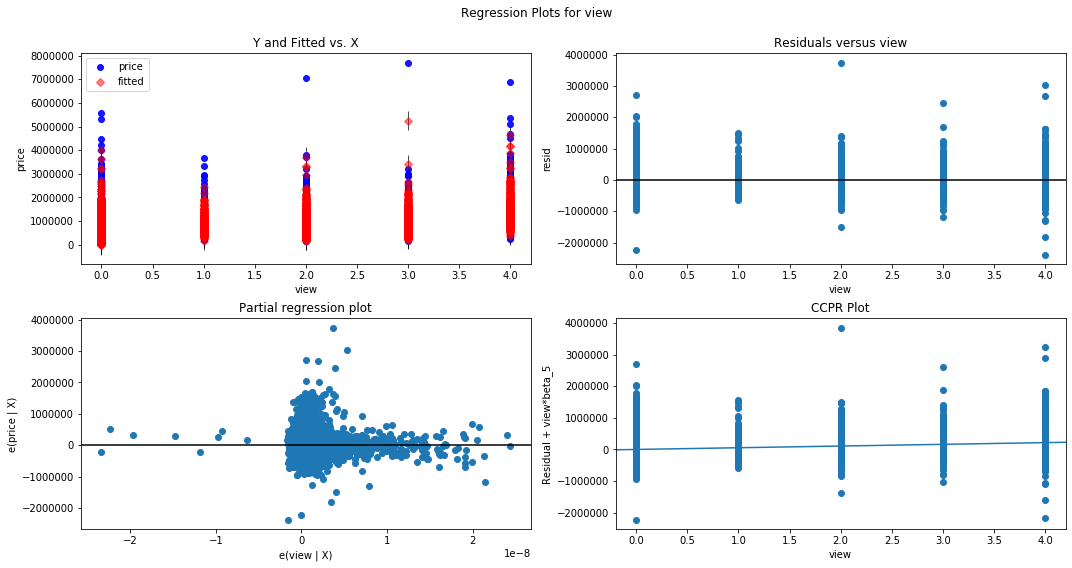

In [325]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "view", fig=fig)
plt.show()

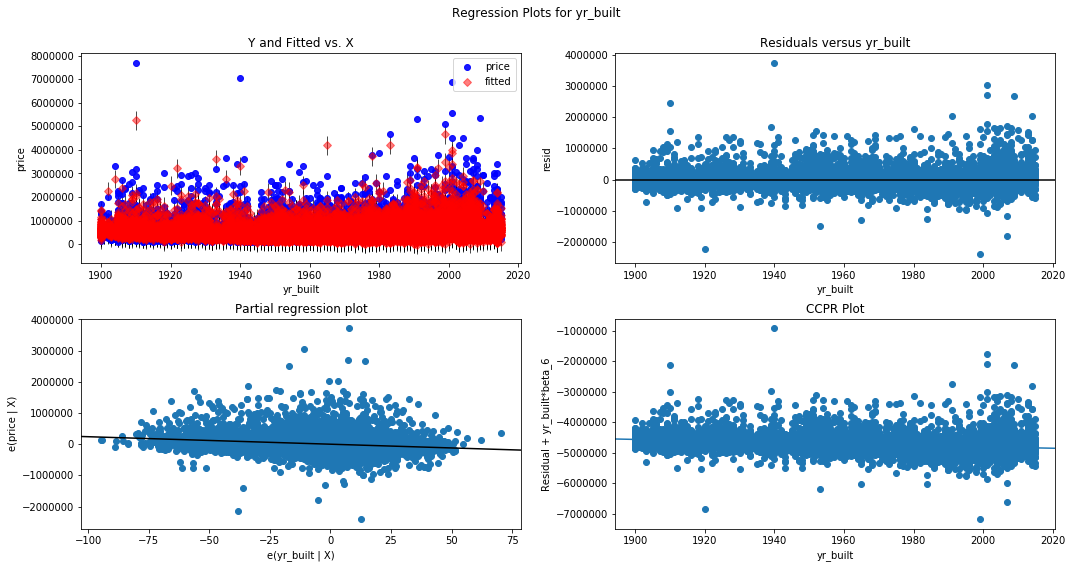

In [326]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "yr_built", fig=fig)
plt.show()

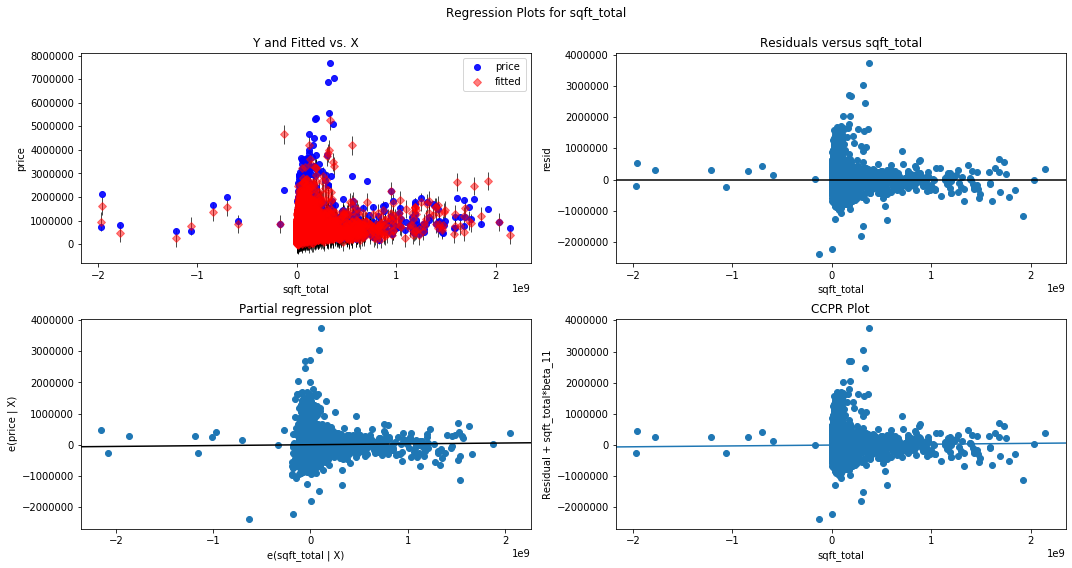

In [327]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "sqft_total", fig=fig)
plt.show()

## Train Split Test - High Tier

In [328]:
#first step
training_data, testing_data = train_test_split(hightier, test_size=0.2)

In [329]:
#split columns
target = 'price'
predictive_cols = training_data.drop(target, axis=1).columns

In [330]:
#fit the model
predictors = '+'.join(predictive_cols)
formula = target + '~' + predictors
model = ols(formula=formula, data=training_data).fit()

In [331]:
# predictions
y_pred_train = model.predict(training_data[predictive_cols])
y_pred_test = model.predict(testing_data[predictive_cols])
# then get the scores:
train_mse = mean_squared_error(training_data[target], y_pred_train)
test_mse = mean_squared_error(testing_data[target], y_pred_test)
print('Training MSE:', train_mse, '\nTesting MSE:', test_mse)

Training MSE: 17644922506.009926 
Testing MSE: 19242199577.212692


Training MSE: \\$132,961.55

Testing MSE: \\$ 138,414,31

## Train Split Test - Medium Tier

In [332]:
#first step
training_data, testing_data = train_test_split(midtier, test_size=0.2)

In [333]:
#split columns
target = 'price'
predictive_cols = training_data.drop(target, axis=1).columns

In [334]:
#fit the model
predictors = '+'.join(predictive_cols)
formula = target + '~' + predictors
model = ols(formula=formula, data=training_data).fit()

In [335]:
# predictions
y_pred_train = model.predict(training_data[predictive_cols])
y_pred_test = model.predict(testing_data[predictive_cols])
# then get the scores:
train_mse = mean_squared_error(training_data[target], y_pred_train)
test_mse = mean_squared_error(testing_data[target], y_pred_test)
print('Training MSE:', train_mse, '\nTesting MSE:', test_mse)

Training MSE: 9434456714.325666 
Testing MSE: 9610446770.355942


Training MSE: \\$97,430.23

Testing MSE: \\$96,801.59

## Train Split Test - Low Tier

In [336]:
#first step
training_data, testing_data = train_test_split(lowtier, test_size=0.2)

In [337]:
#split columns
target = 'price'
predictive_cols = training_data.drop(target, axis=1).columns

In [338]:
#fit the model
predictors = '+'.join(predictive_cols)
formula = target + '~' + predictors
model = ols(formula=formula, data=training_data).fit()

In [339]:
# predictions
y_pred_train = model.predict(training_data[predictive_cols])
y_pred_test = model.predict(testing_data[predictive_cols])
# then get the scores:
train_mse = mean_squared_error(training_data[target], y_pred_train)
test_mse = mean_squared_error(testing_data[target], y_pred_test)
print('Training MSE:', train_mse, '\nTesting MSE:', test_mse)

Training MSE: 1282945462.801876 
Testing MSE: 1370004196.0179832


Training MSE: \\$36,328.78

Testing MSE: \\$34,971.94

# Interpret

In [340]:
# Function for Bedroom Visuals
def bedvisual(data,x,y):
    fig, ax = plt.subplots(figsize=(12,8))

    sns.boxplot(x=x, y=y, data=data)
    sns.regplot(x=x,y=y,data=data)
    ax.set(title=x.title()+' relationship on '+y.title(),
       xlabel=x.title(), ylabel='Price')

    fig.tight_layout()

In [341]:
# Function for Bathroom Visuals
def bathvisual(data,x,y):
    fig, ax = plt.subplots(figsize=(12,8))

    sns.boxplot(x=x, y=y, data=data)
    sns.regplot(x=x,y=y,data=data)
    ax.set(title=x.title()+' relationship on '+y.title(),
       xlabel=x.title(), ylabel='Price')

    fig.tight_layout()

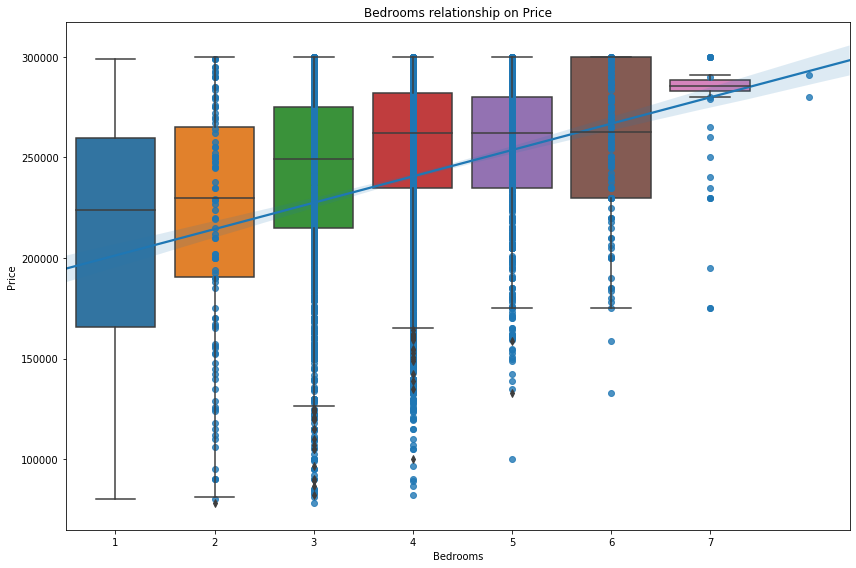

In [342]:
bedvisual(lowtier,'bedrooms','price')

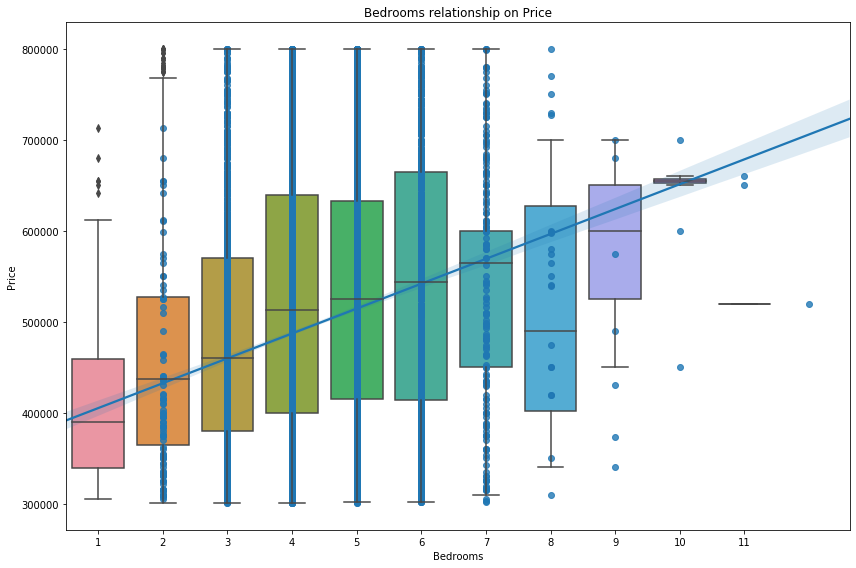

In [343]:
bedvisual(midtier,'bedrooms','price')

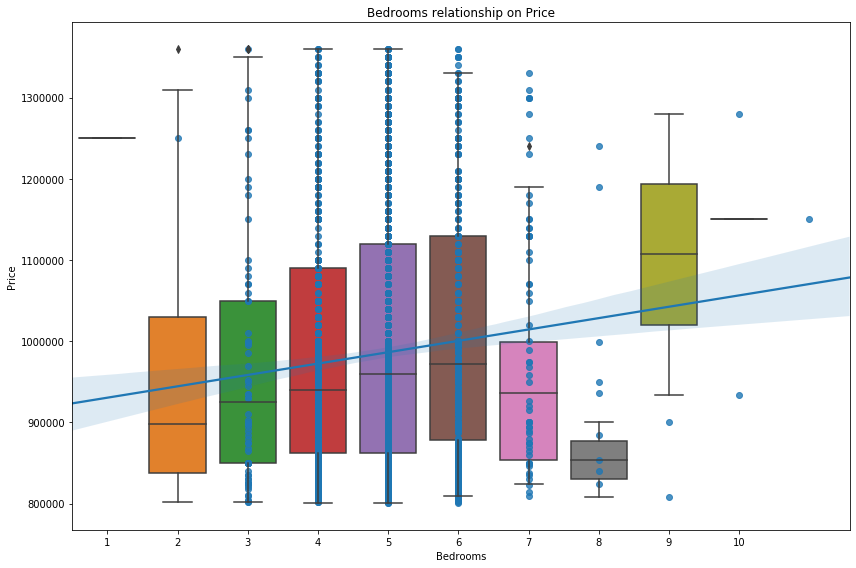

In [344]:
bedvisual(hightier,'bedrooms','price')

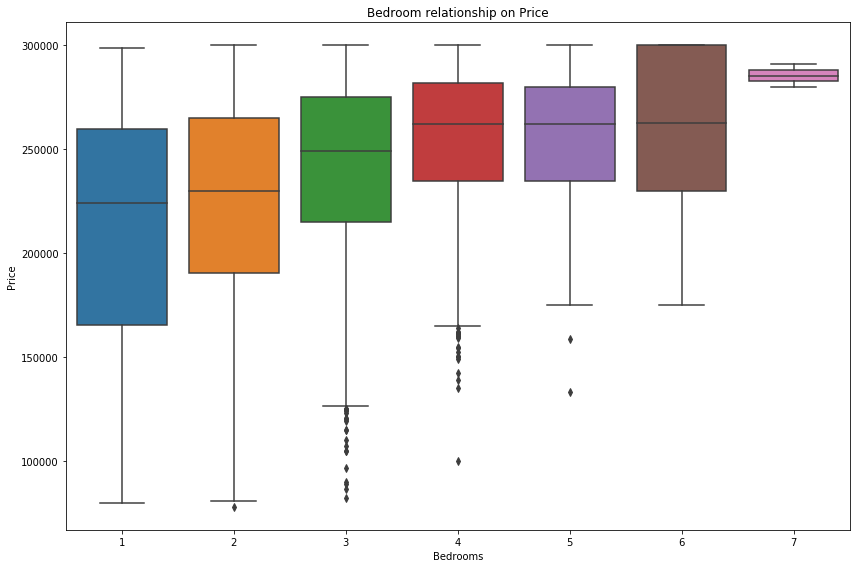

In [345]:
boxvisual(lowtier,'bedrooms','price')

### Bathrooms

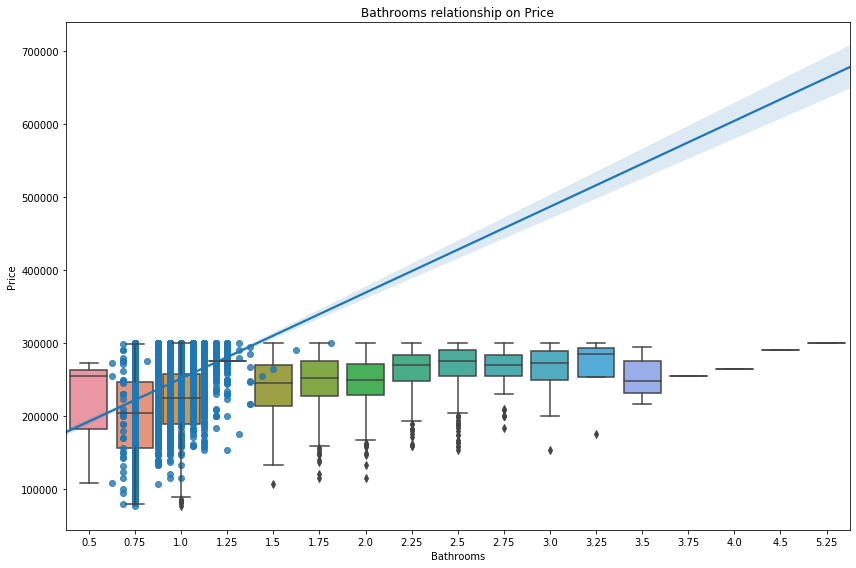

In [346]:
bathvisual(lowtier,'bathrooms','price')

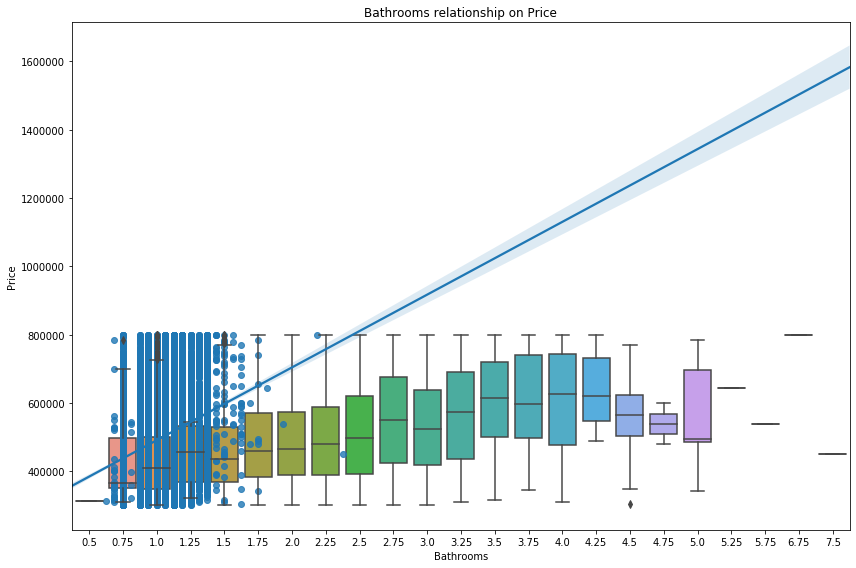

In [347]:
bathvisual(midtier,'bathrooms','price')

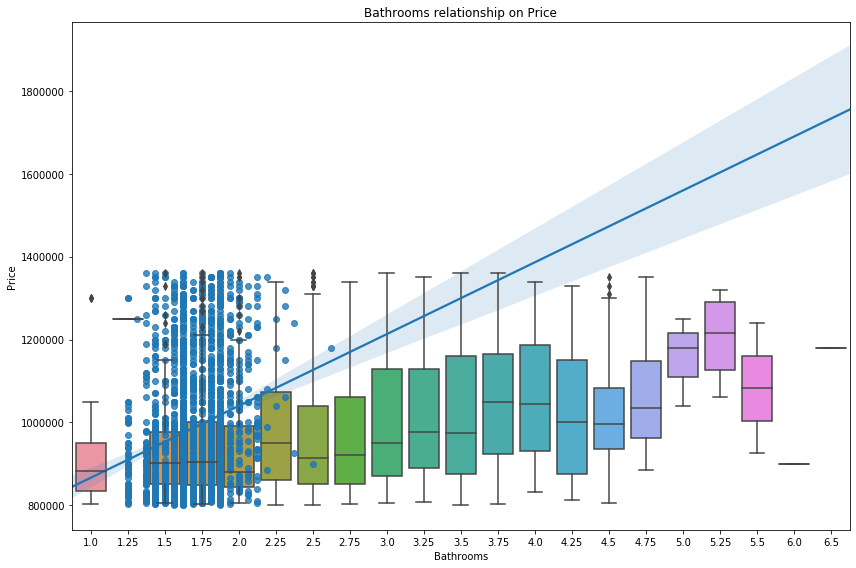

In [348]:
bathvisual(hightier,'bathrooms','price')

### Waterfront

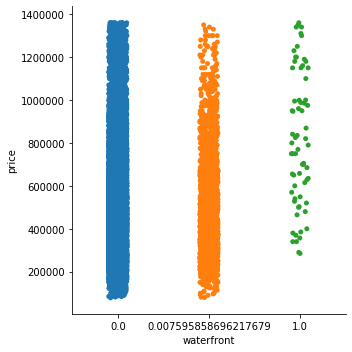

In [349]:
sns.catplot(x='waterfront', y='price', data=kc_data)
ax.set(title='Waterfront & Price', 
       xlabel='Waterfront', ylabel='Price')

fig.tight_layout()

### View

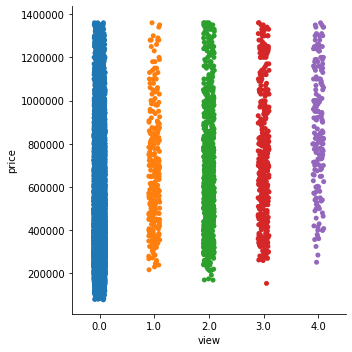

In [350]:
sns.catplot(x='view', y='price', data=kc_data)
ax.set(title='View & Price', 
       xlabel='View', ylabel='Price')

fig.tight_layout()

### SqFt_Habitable

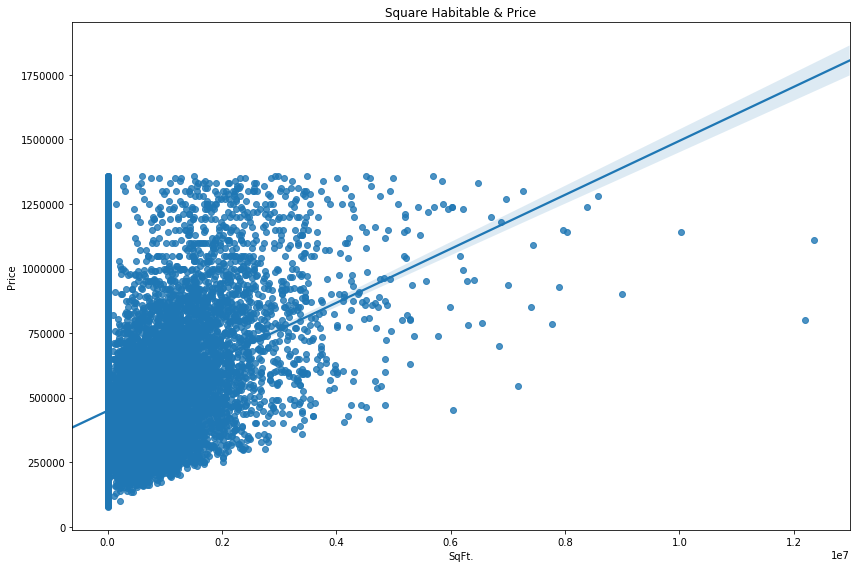

In [351]:
fig, ax = plt.subplots(figsize=(12,8))

sns.regplot(x='sqft_habitable', y='price', data=kc_data)
ax.set(title='Square Habitable & Price', 
       xlabel='SqFt.', ylabel='Price')

fig.tight_layout()

### Coefficients

In [352]:
def coef(df, x_columns, drops=None, target='price', add_constant=False):
    if drops:
        drops.append(target)
        X = df.drop(columns=drops)
    else:
        X = df[x_columns]
    if add_constant:
        X = sm.add_constant(X)
    y = df[target]
    ols = sm.OLS(y, X)
    res = ols.fit()
    return res

In [353]:
low = coef(kc_data,['bedrooms', 'bathrooms', 'floors', 'waterfront', 'zipcode', 'lat',
       'long', 'sqft_total', 'sqft_habitable', 'con4', 'con5', 'view1', 'grd4',
       'grd5', 'grd6'])

In [354]:
mid = coef(kc_data,['bathrooms', 'waterfront', 'view', 'yr_built',
                  'zipcode', 'lat','long', 'sqft_habitable',
                   'con4', 'con5', 'view1','grd7', 'grd8', 'grd9', 
                  'grd10', 'grd11'])

In [355]:
high = coef(kc_data, ['bathrooms', 'waterfront', 'zipcode','long', 'sqft_habitable'])

In [356]:
low.params.round(2).sort_values()

grd5              -74861.24
grd4              -66904.16
grd6              -53040.24
long              -30093.43
zipcode             -367.95
sqft_total             0.00
sqft_habitable         0.06
bedrooms           17205.27
con4               37261.59
floors             65633.84
con5               75716.05
bathrooms          83141.29
view1             131735.41
waterfront        386128.25
lat               684020.95
dtype: float64

In [357]:
mid.params.round(2).sort_values()

yr_built           -1992.04
zipcode             -222.71
sqft_habitable         0.02
long                4938.63
con4               22361.17
view               41985.46
con5               53350.48
view1              54869.82
bathrooms          73145.52
grd7               83116.78
waterfront        188001.11
grd8              197336.36
grd9              367283.10
grd10             495912.97
lat               557679.07
grd11             628020.99
dtype: float64

In [358]:
high.params.round(2).sort_values()

sqft_habitable         0.06
zipcode                2.87
long                 726.55
bathrooms         131409.10
waterfront        315550.12
dtype: float64

# Conclusions & Recommendations

## Observations
- Different incomes have different priorities when it comes to buying/selling/managing a home
- Low income tends to put more priority on pragmatic space, whether that be bedrooms, bathrooms or conditions relative for their income
- Middle income location plays a larger role, with higher quality grade rankings playing a part. With bathrooms once again increasing the value
- High income homes seem to be impacted most by bathrooms, location and whether or not the property is a waterfront property.

## Recommendations
- If you're a seller, adding on a bathroom can increase the value of your home, relative to your income bracket.
- Investing into properties or areas zoned to the waterfront can be lucrative investment opportunities for growth
- Shopping homes between Grades 4-6 for lower income families or renovation projects can provide more competitive pricing as these grades drive down the value of a home